In [17]:
import json
import re
import pandas as pd 
import numpy as np
from nltk.stem.porter import PorterStemmer
import string
from nltk import word_tokenize, pos_tag
import spacy
from collections import Counter
import os
import pickle

In [18]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

In [19]:
filepath = "/Users/chahaksethi/Desktop/Target/data/1m_recipe/recipe1M_layers/layer1.json"
with open(filepath) as json_data:
    recipe = json.load(json_data)

In [20]:
# filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer2.json"
filepath = "/Users/chahaksethi/Desktop/Target/data/1m_recipe/recipe1M_layers/layer2.json"
with open(filepath) as json_data:
    recipe_images = json.load(json_data)

In [21]:
# Set input file directory

# ip_file_dir = "../Data/Target Data/"
ip_file_dir = "/Users/chahaksethi/Desktop/Target/target/target_recipe_project/data/"
# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group4_header.csv'),
                      sep=',', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products_group4.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [22]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
k=3

In [23]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, product_ids=group10['tcin'], max_rank=3)
with open('/Users/chahaksethi/Desktop/Target/target/target_recipe_project/data/embeddings/hier_embeddings3.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map('/Users/chahaksethi/Desktop/Target/target/target_recipe_project/data/embeddings/hier_embeddings3.pkl'),
                                cross_rank=k,
                                bi_rank=30)

pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [24]:
tool_indicator_regex = '(pan|skillet|dish|pot|sheet|grate|whisk|griddle|bowl|oven|saucepan|foil|mortar|pestle|pitcher|bag|cup|stick|blender|paper|knife|glass|brush|colander)'
method_indicator_regex = '(boil|bake|baking|stir|roast|fry|rinse|drain|sift|beat|fold|chop|slice|saute|grate|grill|cut)'



In [25]:
def recipe_load(s,n):
    recipe_instr=[]
    for i in range(s,n):
        title = recipe[i]['title']
        id = recipe[i]['id']
        
        for lis in recipe[i]['instructions']:
            for key, val in lis.items():   
                rem = re.sub("[\(\[].*?[\)\]]", "", val)
                if rem !='':
                    recipe_instr.append(rem)
    return ' '.join(recipe_instr)


In [26]:
def find_tools(instruction_words):
    """
    looks for any and all cooking tools apparent in the instruction text by using the tool_indicator_regex
    variable
    """
    cooking_tools = []
    for word in instruction_words:
        if re.search(tool_indicator_regex, word, flags=re.I):
#             print(word)
            cooking_tools.append(word)
        wordset = set(cooking_tools)
    return [item for item in wordset if item.istitle() or item.title() not in wordset]

def find_methods(instruction_words):
        """
        looks for any and all cooking methods apparent in the instruction text by using the method_indicator_regex
        variable
        """
        cooking_methods = []
        for word in instruction_words:
            if re.search(method_indicator_regex, word, flags=re.I):
                cooking_methods.append(word)
            if re.search('preheat', word, re.I):
                cooking_methods.append('bake')

        wordset = set(cooking_methods)
        return [item for item in wordset if item.istitle() or item.title() not in wordset]


In [27]:
recipe = recipe_load(11000,11001)

instruction_words = word_tokenize(recipe)
cooking_tools = find_tools(instruction_words)
cooking_methods = find_methods(instruction_words)

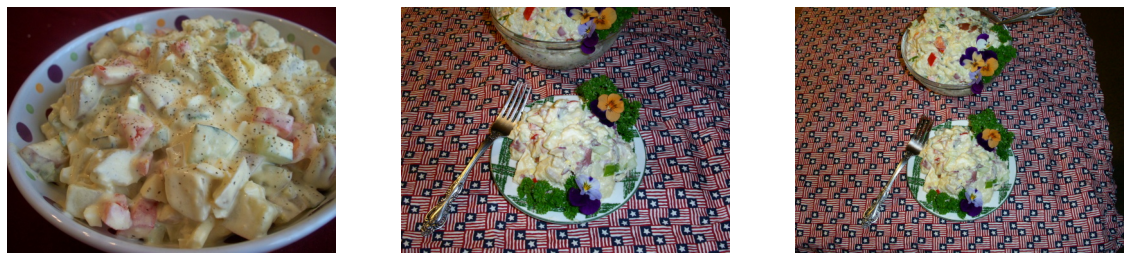

In [28]:
import matplotlib.pyplot as plt
urls = []
for recipe_image in recipe_images:
    if recipe_image['id'] == 'ca596d5fad':
        for image in recipe_image['images']:
            urls.append(image['url'])
images = pm.get_images_urls(urls)

plt.figure(figsize=(20,10))
columns = 3
for i in range(len(images)):
    ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
    plt.axis('off')
    # plt.title(titles[i])
    plt.imshow(images[i])

In [29]:
cooking_tools

['pot', 'bowl', 'oven', 'oven-proof', 'dish', 'colander']

In [30]:
cooking_methods

['Drain', 'boiling', 'drained', 'Bake', 'Chop']

In [31]:
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map('../../data/embeddings/hier_embeddings_products4.pkl'),
                                cross_rank=k,
                                bi_rank=30)

# pm = Mapper(group10)
# dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

cooking__tools = preprocess(cooking_tools)

# Ranked list of product tcin matches for each ingredient - Returns a list of lists 
ranked_match = l2_ranker.rank_products_recipe(cooking__tools, 3)

In [32]:
rslt_df = group10[['title', 'tcin', 'short_desc','price','net_content_quantity_unit_of_measure', 'net_content_quantity_value']]
final_rslt_df=pd.DataFrame()

for i in range(len(ranked_match)):
    rslt_inter = rslt_df.loc[group10['tcin'].isin(ranked_match[i])] 
    tool = cooking__tools[i]
    length = min(len(ranked_match[i]),9)
    for n in range(0,length):
        for j, row in rslt_inter.iterrows():
            if row.tcin == ranked_match[i][n] :
                rslt_inter.loc[j,'rank']=n+1
                rslt_inter.loc[j,'cooking_tool']=tool
                break
    rslt_inter_n=rslt_inter.sort_values('rank')[0:9] 
    final_rslt_df= pd.concat([final_rslt_df,rslt_inter_n], ignore_index=True)

# rslt_inter
df = final_rslt_df.sort_values(by=['cooking_tool', 'price'])
display_df = final_rslt_df[['tcin', 'cooking_tool', 'price']]


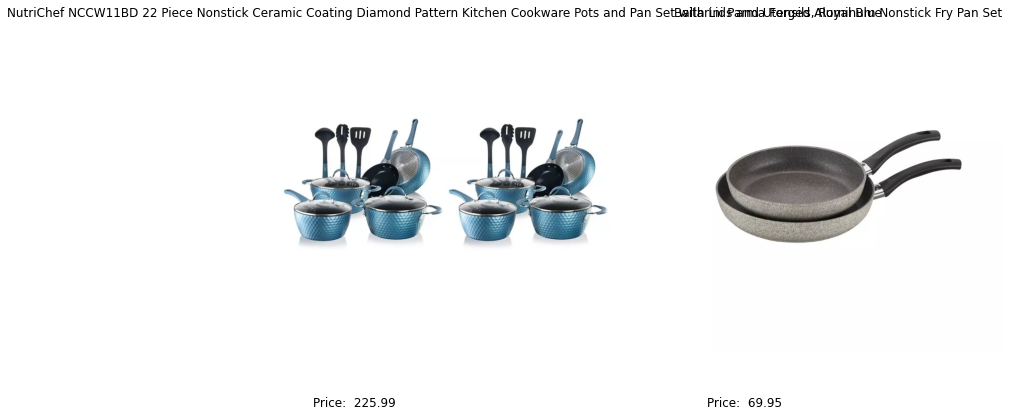

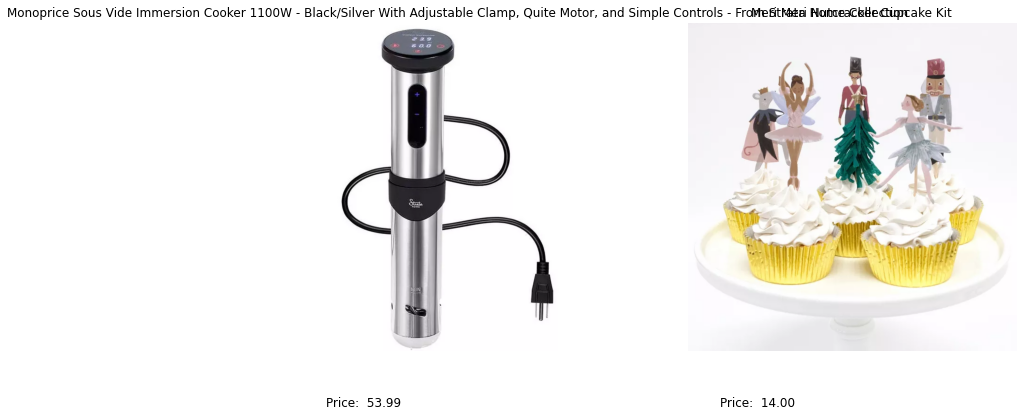

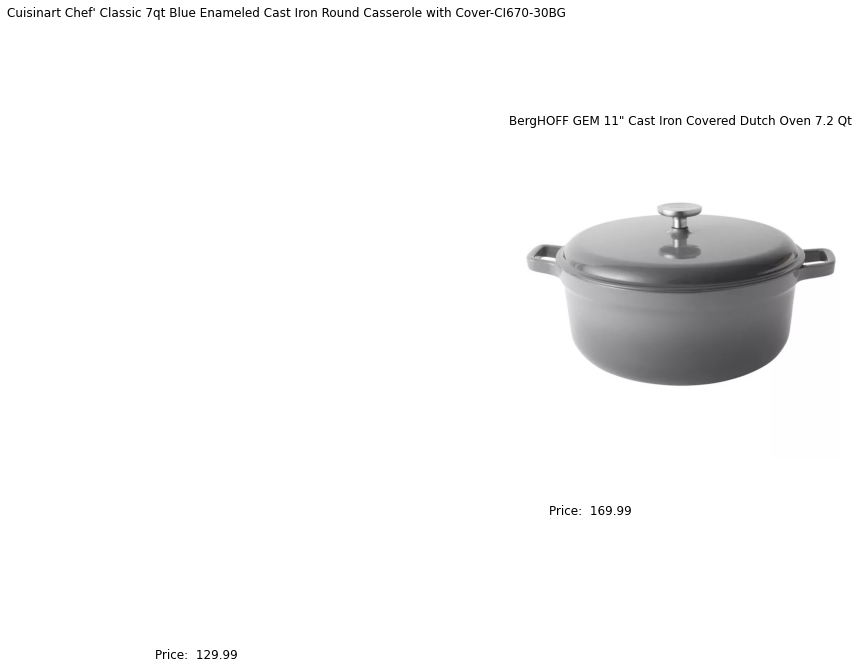

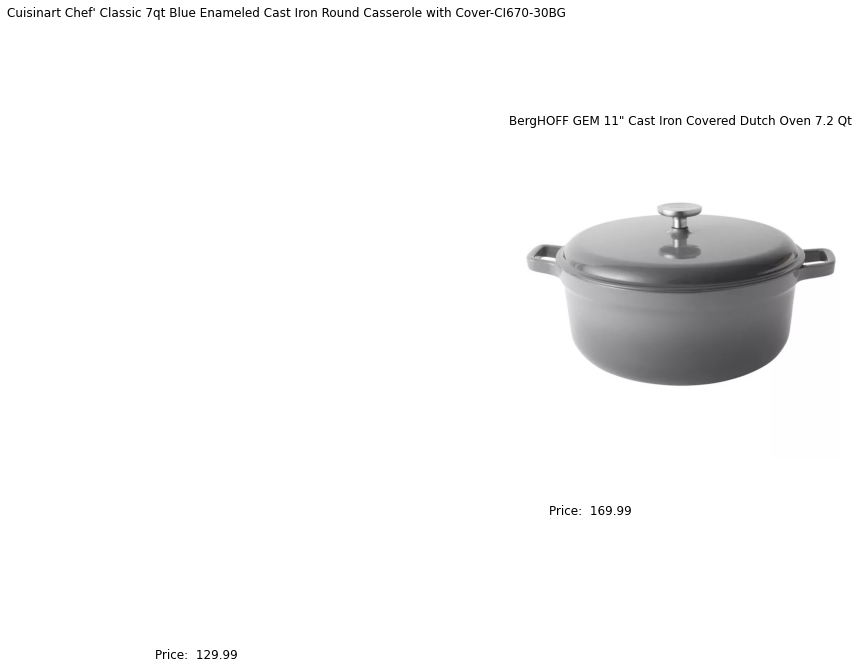

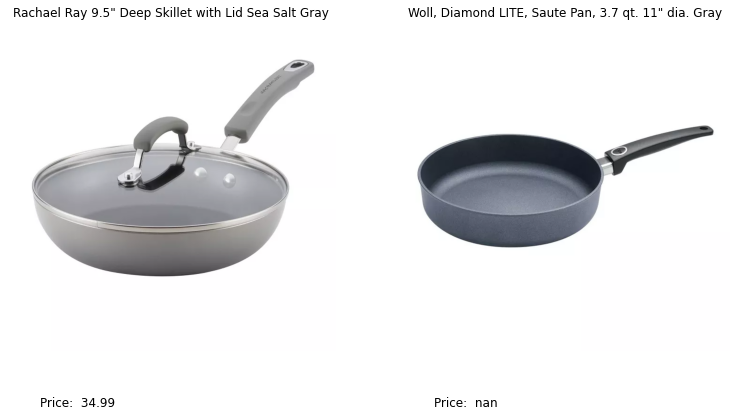

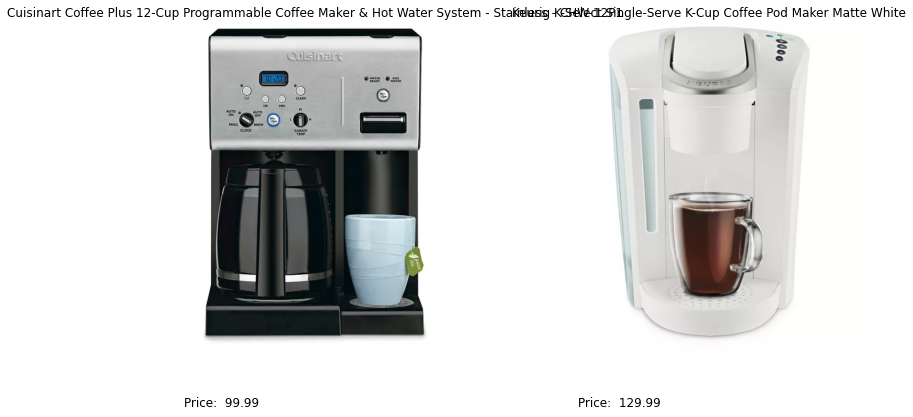

In [33]:
dp.display_products_df_kitchen_gadgets(display_df, 2)

In [ ]:
ner_model = spacy.blank('en')  # create blank Language class
print("Created blank 'en' model")

In [ ]:
TRAIN_DATA = [
    (x, {
        'entities': [(8, 28, 'TOOL'), (74, 89, 'METHOD')]
    })